In [41]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [42]:
def make_dwt_vars(wells_df,logs,levels,wavelet='db3'):

    from scipy.interpolate import interp1d
    import pywt
    
    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]
        
            for i in range(1,max_level+1):

                cA,cD = pywt.dwt(temp_data,wave,mode='symmetric')
                new_depth = np.linspace(min(depth),max(depth),len(cD))
                f = interp1d(new_depth,cD,kind='nearest')
                
                if (i in levels):
                    temp_df[log + '_cD_step_level_' + str(i)] = f(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df,new_df],axis=1)

In [43]:
def make_entropy_vars(wells_df,logs,l_foot):
    
    from skimage.filters.rank import entropy
    from skimage.morphology import rectangle
    from skimage.util import img_as_ubyte
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]       
            footprint = rectangle(l_foot,3)

            image = np.vstack((temp_data,temp_data,temp_data))
            image -= np.median(image) 
            image /= np.max(np.abs(image))
            image = img_as_ubyte(image)

            temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df,new_df],axis=1)

In [6]:
import seaborn as sns

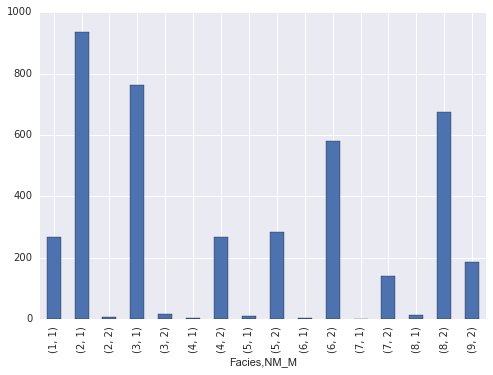

In [35]:
grouped = training_data.groupby(['Facies','NM_M']).count()
grouped['GR'].plot(kind='bar')

### Those proportions indicates that it is farily reasonnable to separate the dataset based on the NM_M attribute

In [59]:
id_NM = training_data.NM_M == 1
id_M = training_data.NM_M == 2

NM_training_data = training_data[id_NM]
M_training_data = training_data[id_M]



In [60]:
logs = ['PHIND','ILD_log10','DeltaPHI']
levels = [4]

NM_training_data = make_dwt_vars(NM_training_data,['GR'],levels)
NM_training_data = make_entropy_vars(NM_training_data,logs,20)

In [61]:
NM_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)
M_training_data.replace(to_replace=np.nan,value=-99999,inplace=True)

In [62]:
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn import ensemble

In [66]:
names = list(np.unique(NM_training_data['Well Name']))
grouped = NM_training_data.groupby(['Well Name'])
scores = []

for name in names:

    test = grouped.get_group(name)
    X_test = test.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1).values
    y_test = test['Facies'].values

    train_names = names.copy()
    train_names.remove(name)
    train = pd.DataFrame()

    for train_name in train_names:
        train = train.append(grouped.get_group(train_name))

    id_train_NM = train.Facies <= 3
    train = train [id_train_NM]
    X_train = train.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1).values
    y_train = train['Facies'].values

    #The prediction begins

    #We start with oversampling minority classes
    smt = SMOTE()
    X_train, y_train = smt.fit_sample(X_train,y_train)

    clf = ensemble.RandomForestClassifier(n_estimators=500,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    #Scoring
    score = metrics.f1_score(y_test, y_pred, average='weighted')
    scores.append(score)
    print('********')
    print('Blind well is {0}, F1 score : {1:.4%}\n'.format(name,score))

print("="*30)
print('*********** RESULT ***********')
print("="*30)
print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))


********
Blind well is ALEXANDER D, F1 score : 73.7662%

********
Blind well is CHURCHMAN BIBLE, F1 score : 52.0120%

********
Blind well is CROSS H CATTLE, F1 score : 39.6076%

********
Blind well is KIMZEY A, F1 score : 60.1806%

********
Blind well is LUKE G U, F1 score : 62.2063%

********
Blind well is NEWBY, F1 score : 58.0120%

********
Blind well is NOLAN, F1 score : 64.4372%

********
Blind well is SHANKLE, F1 score : 49.9894%

********
Blind well is SHRIMPLIN, F1 score : 63.4860%

*********** RESULT ***********

Average  F1-score is 58.1886%


In [68]:
names = list(np.unique(M_training_data['Well Name']))
grouped = M_training_data.groupby(['Well Name'])
scores = []

for name in names:

    test = grouped.get_group(name)
    X_test = test.drop(['Formation', 'Well Name', 'Depth','Facies','ILD_log10'], axis=1).values
    y_test = test['Facies'].values

    train_names = names.copy()
    train_names.remove(name)
    train = pd.DataFrame()

    for train_name in train_names:
        train = train.append(grouped.get_group(train_name))

    id_train_NM = train.Facies >= 4
    train = train [id_train_NM]
    X_train = train.drop(['Formation', 'Well Name', 'Depth','Facies','ILD_log10'], axis=1).values
    y_train = train['Facies'].values

    #The prediction begins

    #We start with oversampling minority classes
    smt = SMOTE()
    X_train, y_train = smt.fit_sample(X_train,y_train)

    clf = ensemble.RandomForestClassifier(n_estimators=500,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    #Scoring
    score = metrics.f1_score(y_test, y_pred, average='weighted')
    scores.append(score)
    print('********')
    print('Blind well is {0}, F1 score : {1:.4%}\n'.format(name,score))

print("="*30)
print('*********** RESULT ***********')
print("="*30)
print('\nAverage  F1-score is {:.4%}'.format(np.mean(scores)))

********
Blind well is ALEXANDER D, F1 score : 43.0936%

********
Blind well is CHURCHMAN BIBLE, F1 score : 51.6339%

********
Blind well is CROSS H CATTLE, F1 score : 36.0306%

********
Blind well is KIMZEY A, F1 score : 35.2333%

********
Blind well is LUKE G U, F1 score : 59.6101%

********
Blind well is NEWBY, F1 score : 23.0683%

********
Blind well is NOLAN, F1 score : 38.3896%

********
Blind well is Recruit F9, F1 score : 94.7368%

********
Blind well is SHANKLE, F1 score : 45.4903%

********
Blind well is SHRIMPLIN, F1 score : 38.8989%

*********** RESULT ***********

Average  F1-score is 46.6185%
